# Programming Assignment: Fruit Quality Inspection and Generation

In the world of automated food inspection, trusting your model is just as important as its accuracy. Before a system can responsibly sort fresh produce from spoiled, you need to understand *why* it makes those decisions. Does your model categorize a fruit as "Rotten" because of a visible mold spot, or is it cheating by looking at the background color?

This assignment challenges you to dig inside the brain of a deep learning model. You will work with a pre-trained computer vision system designed to inspect fruit. Your goal is to build a suite of visualization tools to examine its internal features, explain its decisions, and even generate new training data when real samples are scarce.

This is a journey from the inside out. You will start by dissecting the internal feature maps of the model to see how it builds understanding from pixels. Then, you will move to decision interpretability to pinpoint exactly which parts of an image drive its predictions. Finally, in the optional section, you will step beyond analysis into creation, using generative AI to synthesize realistic fruit images from scratch.

Specifically, you will perform the following steps:

* **Visualizing Feature Hierarchy**: You will peel back the layers of a Convolutional Neural Network (CNN) to observe how it transforms raw pixel data into abstract features like edges, textures, and shapes.
* **Pinpointing Sensitivity with Saliency**: You will implement **Saliency Maps** to calculate the gradient of the prediction of the model with respect to the input pixels, identifying exactly which tiny details triggered the decision.
* **Mapping Attention with Grad-CAM**: You will use **Class Activation Mapping** to generate heatmaps that highlight the specific regions of the fruit that drove the classification.
* **Generating Synthetic Data**: Finally, in an optional section, you will leverage **Stable Diffusion** to solve the problem of limited training data by generating realistic images of rare food defects.

Let's begin building the tools to see what your AI sees!

---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

* To submit your notebook for grading, first save it by clicking the 💾 icon on the top left of the page and then click on the `Submit assignment` button on the top right of the page.
---

## Table of Contents
- [Imports](#0)
- [1 - Setting the Stage: Data and Model](#1)
    - [1.1 - The Fruit Dataset](#1-1)
    - [1.2 - Loading the Pre-trained Inspector](#1-2)
    - [1.3 - Making a Prediction](#1-3)
- [2 - Visualizing Internal Representations](#2)
    - [2.1 - Hooking into the Hierarchy](#2-1)
    - [2.2 - Capturing the Hierarchy](#2-2)
        - **[Exercise 1 - cnn_feature_hierarchy](#ex-1)**
    - [2.3 - Processing Feature Maps](#2-3)
        - **[Exercise 2 - feature_map_strip](#ex-2)**
- [3 - Pixel Level Scrutiny: Saliency Maps](#3)
    - **[Exercise 3 - saliency_map](#ex-3)**
- [4 - Regional Attention: Class Activation Maps](#4)
    - **[Exercise 4 - simplified_cam](#ex-4)**    
- [5 - Comparison of Interpretability Techniques](#5)
- [6 - (Optional) Dreaming up Defects: Generative AI](#6)
    - [6.1 - Setting up Stable Diffusion](#6-1)
        - [Ungraded Exercise 1 - load_sd_pipeline](#exu-1)
    - [6.2 - Generating Synthetic Data](#6-2)
        - [Ungraded Exercise 2 - generate_sd_image](#exu-2)
    - [6.3 - Peeking into the Diffusion Process](#6-3)
        - [Ungraded Exercise 3 - denoising_movie](#exu-3)

<a name='0'></a>
## Imports

In [1]:
import torch
from torch.nn import functional as F

In [2]:
import gc
from pathlib import Path

from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

import helper_utils
import unittests

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1 - Setting the Stage: Data and Model

Before you can audit the decision making process of an AI, you need to establish the environment it operates in. This involves defining the data that represents the real world problem and loading the intelligent agent, the pre-trained model, that will perform the inspection.

<a name='1-1'></a>
### 1.1 - The Fruit Dataset

The foundation of any vision system is its data. For this assignment, you will work with a curated subset of the [Fruit and Vegetable Disease (Healthy vs Rotten)](https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten) dataset.

To simulate a targeted inspection line, you will focus on three specific fruit categories: **Apples**, **Mangoes**, and **Tomatoes**. For each fruit, the dataset provides two clear conditions:

* **Healthy**: Represents fresh, sellable produce.
* **Rotten**: Represents damaged produce that must be rejected.

**Dataset Overview:**
- **Total images**: 60 images (10 per category for each fruit type).
- **Classes**: 2 (Fresh = 0, Rotten = 1).
- **Image size**: Variable sizes.

You have access to 10 randomly selected images for each category (indexed from 0 to 9), organized in the following structure:

```text
./fruits_subset/            (Total 60 Images)
│
├── Apple_Healthy/          (Total 10 Images)
│   ├── FreshApple_0.jpg
│   ├── ...
│   └── FreshApple_9.jpg
│
├── Apple_Rotten/           (Total 10 Images)
│   ├── rottenApple_0.jpg
│   ├── ...
│   └── rottenApple_9.jpg
│
├── Mango_Healthy/          (Total 10 Images)
│   ├── FreshMango_0.jpg
│   ├── ...
│   └── FreshMango_9.jpg
│
├── Mango_Rotten/           (Total 10 Images)
│   ├── rottenMango_0.jpg
│   ├── ...
│   └── rottenMango_9.jpg
│
├── Tomato_Healthy/         (Total 10 Images)
│   ├── FreshTomato_0.jpg
│   ├── ...
│   └── FreshTomato_9.jpg
│
└── Tomato_Rotten/          (Total 10 Images)
    ├── rottenTomato_0.jpg
    ├── ...
    └── rottenTomato_9.jpg

* Set the directory path to point to the dataset location.

In [3]:
# Root path for healthy and rotten apple, mango, and tomato images
dataset_path = "./fruits_subset/"

It is essential to visually verify your data before feeding it into a model. This helps you understand the variations in lighting, background, and texture that the model must handle.

* Run the cell below to visualize random healthy and rotten samples from the dataset.
    * Each execution will display randomly selected images from each category.

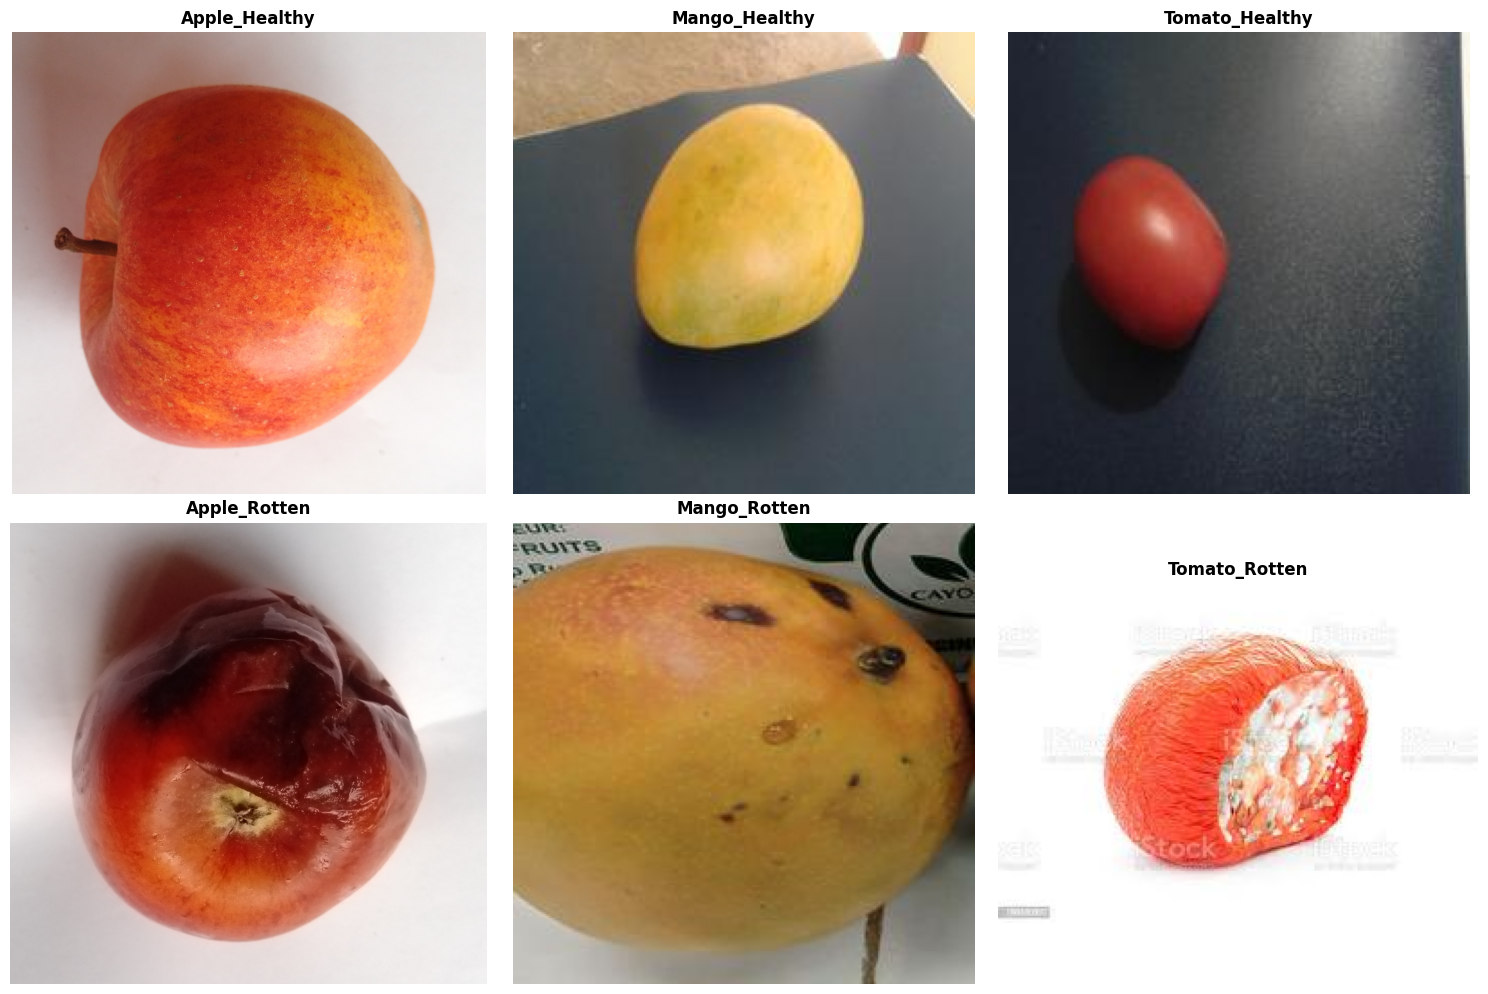

In [4]:
# Visualize random healthy and rotten samples from the dataset
helper_utils.plot_samples_from_dataset(dataset_path)

<a name='1-2'></a>
### 1.2 - Loading the Pre-trained Inspector

After inspecting the images available to you, it is time to set up the engine of your visual inspection system. In professional computer vision workflows, you rarely build a model from scratch. Instead, you leverage powerful backbones that have already learned to see.

You will use a **ResNet-50** architecture. This model is an industry standard known for its deep feature hierarchy. For this assignment, the architecture has been adapted for binary classification to distinguish between fresh and rotten fruit. You are provided with weights that are already fine-tuned for this specific task. This allows you to skip the training phase and jump straight into the heart of this assignment: **interpretability**.

* Load the pre-trained model and move it to the correct device.

In [5]:
# Load the pre-trained weights for the ResNet-50 model
fruits_model = helper_utils.load_model("./models/fruits_quality_model.pth", device)
# Move the model to device
fruits_model = fruits_model.to(device)

Starting loading model...
Changing the final layer to a binary classification layer...
Loading the model weights...
Loading the model weights into the model...

Model loaded successfully!



It is often helpful to inspect the architecture you are working with. The `display_model_architecture` function below prints a summary of the ResNet-50 layers, showing each layer's name, type, and number of parameters.

Pay attention to how the network is structured:
* **Early Layers**: Convolutional layers that capture small, low-level details.
* **Deeper Layers**: Sequential blocks that combine features into larger, abstract patterns.

Understanding this map is essential for the next steps. To visualize activations or generate heatmaps, you need to know exactly *where* to look. By identifying specific layers now, you will be able to choose the most informative points to monitor later when interpreting the model's decisions.

* Inspect the model architecture to understand the layers you will be probing.

In [6]:
# Display the model architecture
helper_utils.display_model_architecture(fruits_model)

Layer Hierarchy,Layer Type,Parameters
conv1,"Conv2d (7, 7)","9,408"
bn1,BatchNorm2d,128
relu,ReLU,0
maxpool,MaxPool2d,0
layer1,Sequential,"215,808"
└─ 0,Bottleneck,"75,008"
└─ 1,Bottleneck,"70,400"
└─ 2,Bottleneck,"70,400"
layer2,Sequential,"1,219,584"
└─ 0,Bottleneck,"379,392"


<a name='1-3'></a>
### 1.3 - Making a Prediction

Now, let's put the inspector to work. You will use an interactive tool to feed images from your dataset into the model and observe the results in real time.

* Run the cell below to launch the prediction interface.
* Select a directory from the dropdown menu (e.g., `Apple_Rotten`) to view the predictions for that specific fruit category.
    * You can switch between different directories to audit different fruits without needing to re-execute the cell.

In [ ]:
# Launch the prediction interface
helper_utils.predict_fruit_quality(fruits_model, dataset_path, device)

<br>

**As you watch the result, ask yourself:** How did the model know?

Did it actually recognize the texture of the skin? Did it spot a defect? Or is it just guessing based on the overall color? Right now, the model is a "black box". It gives an answer, but no explanation. In the next section, you will start building the tools to look inside that box.

<a name='2'></a>
## 2 - Visualizing Internal Representations

You have seen the final decision of the model, but how did it arrive there?

A Convolutional Neural Network (CNN) does not see an "apple" or a "tomato" all at once. It builds this understanding hierarchically. The early layers typically act as edge and texture detectors, identifying simple curves or color gradients on the skin of the fruit. As the data flows deeper, these simple features are combined into more complex patterns, eventually recognizing shapes like a stem, a bruise, or a patch of mold.

In this section, you will peel back the layers of your network to observe this transformation in real time.

<a name='2-1'></a>
### 2.1 - Hooking into the Hierarchy

To visualize these internal states, you need a way to access the data flowing through the network. By default, PyTorch discards intermediate feature maps (the outputs of hidden layers) to save memory once the forward pass is complete. To peek inside, you need a **hook**.

A hook is a function that you register to a specific layer. It acts like a wiretap: every time that layer processes an input, the hook intercepts the output and saves a copy of it before the data moves on.

You will use the `grab` helper function to create these hooks. When called with the `activations` dictionary and a `name`, it returns a closure that, once attached to a layer, saves that layer's output tensor into `activations` under the specified `name`. The function explicitly uses `.detach()` to remove the tensor from the computation graph, ensuring it does not track gradients, which saves memory and makes the data easier to handle.

In short, this tool allows you to capture and label feature maps from chosen layers, making it possible to inspect how the network processes an image at different stages.

* Run the cell below to define the `grab` helper function.

In [7]:
def grab(activations, name):
    """
    Creates a forward hook function to capture and store the output of a specific layer.

    Arguments:
        activations: A dictionary where the captured layer output will be stored.
        name: The key under which the output tensor will be saved in the dictionary.

    Returns:
        _hook: The closure function to be registered as a hook.
    """
    # Define the internal hook function following the PyTorch hook signature (module, input, output)
    def _hook(_, __, out): 
        # Detach the output tensor from the gradient graph and store it in the dictionary
        activations[name] = out.detach()
        
    # Return the closure to be registered as a hook
    return _hook

<a name='2-2'></a>
### 2.2 - Capturing the Hierarchy

Your first objective is to build a tool that captures the state of the network at various depths. This will allow you to take a single image of a fruit and extract a "fingerprint" of how that image is represented at the beginning, middle, and end of the network.

<a name='ex-1'></a>
### Exercise 1 - cnn_feature_hierarchy

Implement `cnn_feature_hierarchy` to visualize how the internal representations of the network evolve. This function uses a pre-trained model (with a `ResNet-50` backbone) and a pre-processed input tensor to capture feature maps from various depths of the network.

**Assume Preprocessed Input**

* `img` is already:
    * **RGB**
    * **center cropped** to `224×224`
    * **normalized** with ImageNet statistics (`mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`)
    * **shaped** (`1, 3, 224, 224`) and placed on the same device as model.

**Your Task**:

* Identify the specific layers you want to inspect. You need to target the following five points in the model:
    * `conv1`
    * The first convolution of the first bottleneck block in:
        * `layer1` (`layer1[0].conv1`)
        * `layer2` (`layer2[0].conv1`)
        * `layer3` (`layer3[0].conv1`)
        * `layer4` (`layer4[0].conv1`)
* Register a forward hook on each of these layers using the `grab` function.
* Store the handle returned by `register_forward_hook` in a list so you can access it later.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you find yourself stuck, here is a more detailed breakdown.

**Registering the Hooks**: You can organize the layers in a dictionary and loop through them.

```python
# Map the string names to the actual model attributes
layers = {
    "conv1": model.conv1,
    "layer1": model.layer1[0].conv1,
    .
    .
    .
}

hooks = []

for name, layer in layers.items():

    hook_function = # Use the `grab` function and pass in `activations` and `name`

    hook_handle = # Use the `register_forward_hook` function of the `layer` and pass in `hook_function`
    
    # Use `append` to add `hook_handle` to the `hooks` list
```

</details>

In [8]:
# GRADED FUNCTION: cnn_feature_hierarchy

def cnn_feature_hierarchy(img, model):
    """
    Visualizes the feature hierarchy of a CNN by capturing feature maps 
    from specific layers during a forward pass.

    This function attaches hooks to key convolutional layers in a ResNet-style 
    architecture to extract intermediate representations.

    Arguments:
        img: The input tensor (image) to process.
        model: The pretrained neural network module to use for feature extraction.

    Returns:
        activations: A dictionary mapping layer names to their captured 
                     feature-map tensors.
    """

    # Initialize an empty dictionary to store the captured activations
    activations = {}
    
### START CODE HERE ###

    # Define a dictionary mapping descriptive names to the specific model layers to probe
    layers = { 
        # Register forward hook for the first convolution layer
        "conv1": model.conv1,
        # Register forward hook for the first convolution layer in the first layer of the model
        "layer1": model.layer1[0].conv1,
         # Register forward hook for the first convolution layer in the second layer of the model
        "layer2": model.layer2[0].conv1,
        # Register forward hook for the first convolution layer in the third layer of the model
        "layer3": model.layer3[0].conv1,
        # Register forward hook for the first convolution layer in the fourth layer of the model
        "layer4": model.layer4[0].conv1
    } 

    ### END CODE HERE ###

    # Initialize a list to track the registered hook handles for cleanup
    hooks = []
    
### START CODE HERE ###

    # Iterate through the dictionary to register hooks on each selected layer
    for name, layer in layers.items():
        
        # Create a specific hook closure for the current layer using the 
        # `grab` helper function
        hook_function = grab(activations, name)
        
        # Register the forward hook on the layer and store the returned handle
        hook_handle = layer.register_forward_hook(hook_function)
        
        # Append the `hook_handle` to `hooks` list
        hooks.append(hook_handle)
    
    ### END CODE HERE ###

    # Perform the forward pass to trigger the hooks and capture data
    with torch.no_grad():
        _ = model(img) 

    # Remove all hooks to clean up the model and prevent memory leaks
    for h in hooks:  
        h.remove() 

    return activations

In [9]:
# Verify your implementation

# Load and preprocess a sample image
image_path = "./fruits_subset/Apple_Healthy/FreshApple_3.jpg"
img = helper_utils.preprocess_image(image_path, device)

# Compute the activations
activations = cnn_feature_hierarchy(
    img=img,
    model=fruits_model
)

# Check all keys and shapes
print("Activations Keys and Shapes:\n")
for name, tensor in activations.items():
    print(f"{name}:\t{tensor.shape}")

Activations Keys and Shapes:

conv1:	torch.Size([1, 64, 112, 112])
layer1:	torch.Size([1, 64, 56, 56])
layer2:	torch.Size([1, 128, 56, 56])
layer3:	torch.Size([1, 256, 28, 28])
layer4:	torch.Size([1, 512, 14, 14])


#### Expected Output:

```
Activations Keys and Shapes:

conv1:	torch.Size([1, 64, 112, 112])
layer1:	torch.Size([1, 64, 56, 56])
layer2:	torch.Size([1, 128, 56, 56])
layer3:	torch.Size([1, 256, 28, 28])
layer4:	torch.Size([1, 512, 14, 14])
```

In [10]:
# Test your code!
unittests.exercise_1(cnn_feature_hierarchy)

 All tests passed!


<br>

Now that you have confirmed your code works, you can explore! The block below contains a variety of images from the dataset. Use them to see how the internal features of the model change depending on whether it looks at a fresh apple or a rotten tomato.

<details>
<summary><b><font color="white">📸 List of Image Paths to test with (Click to expand)</font></b></summary>
<br>
You can copy any of the paths below:

🍎 Apple

From **Apple_Healthy** (from index `0` to `9`)

* `image_path = "./fruits_subset/Apple_Healthy/FreshApple_0.jpg"`

From **Apple_Rotten** (from index `0` to `9`)

* `image_path = "./fruits_subset/Apple_Rotten/rottenApple_7.jpg"`

🥭 Mango

From **Mango_Healthy** (from index `0` to `9`)

* `image_path = "./fruits_subset/Mango_Healthy/FreshMango_4.jpg"`

From **Mango_Rotten** (from index `0` to `9`)

* `image_path = "./fruits_subset/Mango_Rotten/rottenMango_1.jpg`

🍅 Tomato

From **Tomato_Healthy** (from index `0` to `9`)

* `image_path = "./fruits_subset/Tomato_Healthy/FreshTomato_5.jpg"`

From **Tomato_Rotten** (from index `0` to `9`)

* `image_path = "./fruits_subset/Tomato_Rotten/rottenTomato_7.jpg"`

<br>

💡 You have images numbered from `0` to `9` in each folder. Feel free to change the number in the filename (e.g., changing `FreshApple_0.jpg` to `FreshApple_1.jpg`) to test with different images!

</details>

In [11]:
# EDITABLE CELL: Feel free to change the image path

# Define the file path for an image for feature visualization
image_path = "./fruits_subset/Apple_Healthy/FreshApple_3.jpg"

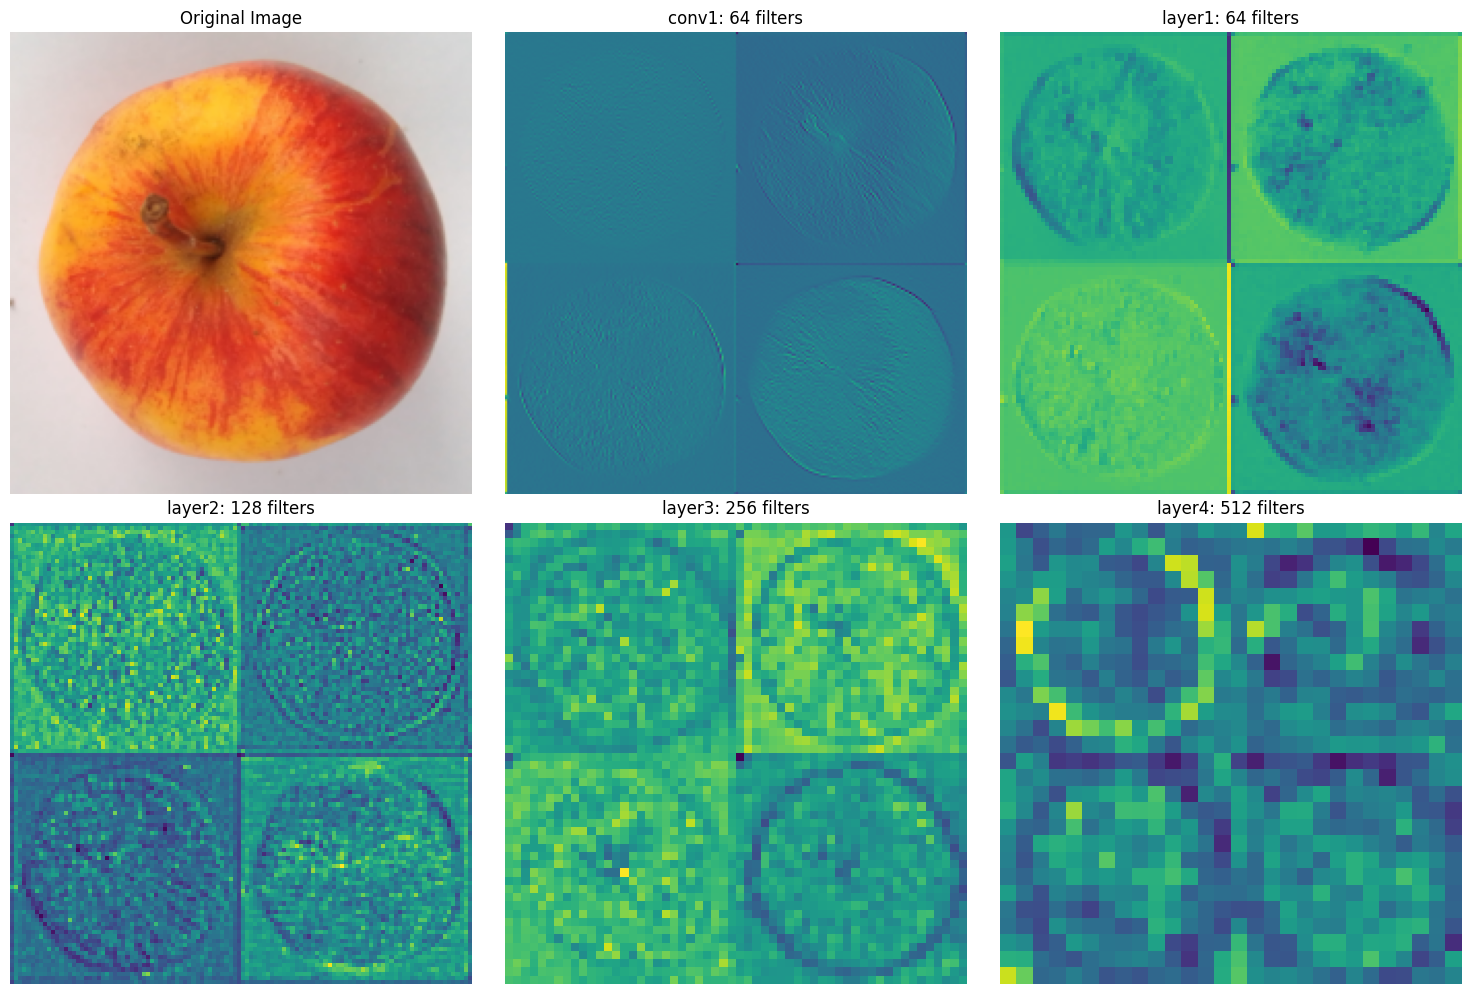

In [12]:
# Preprocess the sample image
img = helper_utils.preprocess_image(image_path, device)

# Compute the activations
activations = cnn_feature_hierarchy(
    img=img,
    model=fruits_model
)

# Display the feature hierarchy for the given image
helper_utils.display_feature_hierarchy(activations, img)

<a name='2-3'></a>
### 2.3 - Processing Feature Maps

You now have the raw data, but it is hard to interpret. Early layers have high resolution but few channels, while deeper layers have low resolution but hundreds of channels. To make sense of this, you need to standardize these representations.

In this task, you will build a compact visual summary that shows the strongest responding feature at five depths of the model. You will create a "visual strip" by automatically selecting the single most active channel, the feature the network is "shouting" about the loudest, and resizing it to match the original image. This creates a clear, side-by-side comparison of how the focus of the network shifts from simple edge and texture responses toward more abstract patterns as depth increases.

<a name='ex-2'></a>
### Exercise 2 - feature_map_strip

Implement `feature_map_strip`. This function builds a visual summary by identifying and resizing the most significant feature captured at five different depths of the network.

**Your Task**:

* **Retrieve Raw Features**: Use the `cnn_feature_hierarchy` function you implemented in `Exercise 1` to get the raw feature maps for the image.
* **Process Each Layer**: Iterate through the layers in order: `["conv1", "layer1", "layer2", "layer3", "layer4"]`. For each layer's feature map:
    * **Identify the Top Channel**: Calculate the mean activation across the spatial dimensions (height and width) for every channel. Find the index of the channel with the highest mean.
    * **Slice**: (This is already implemented for you) Extract just that single channel, keeping the tensor 4D (maintaining the batch and channel dimensions).
    * **Upsample**: Resize this single-channel feature map to `224x224` using `"bilinear"` interpolation. Ensure you set `align_corners` to `False`.
* **Normalize**: Scale the pixel values of the upsampled map to the range `[0, 1]` using min-max normalization. Add a small epsilon, `1e-8`, to the denominator to prevent division by zero.
* **Append** each processed tensor to a list before returning it.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you find yourself stuck, here is a more detailed breakdown.

**Retrieving Features**: Simply call the function you wrote in the previous exercise.
* <code>feats = call cnn_feature_hierarchy(with img and model)</code>

**Finding the "Top" Channel**: You need to reduce the spatial dimensions (2 and 3) to find the average intensity per channel.
```python
# Calculate mean over spatial dims (2 and 3)
avg_activation = fm.mean(dim=(...))

# Get the integer index of the highest activation
idx = avg_activation.argmax().item()
```
<br>

**Upsampling**: Use PyTorch's functional API for interpolation.
* sel = F.interpolate(sel, size=(..., ...), mode="bilinear", align_corners=False)</code>

**Normalization**: Standard Min-Max formula: $(x−min)/(max−min)$. If `minimum` is calculated using `sel.min()`, how will `maximum` be calculated?
* <code>sel = (sel - minimum) / (maximum - minimum + epsilon)</code>

</details>

In [13]:
# GRADED FUNCTION: feature_map_strip

def feature_map_strip(img, model):
    """
    Processes an image through a model to extract, select, and upsample 
    representative feature maps from specific layers.

    This function retrieves raw feature activations, identifies the most 
    active channel based on mean activation, and upsamples it to match 
    the original image resolution for visualization purposes.

    Arguments:
        img: The input image tensor.
        model: The pretrained neural network module used for feature extraction.

    Returns:
        upsampled: A list of tensors, each representing the most active 
                   channel from a specific layer, resized to 224x224 and 
                   normalized to [0, 1].
    """

### START CODE HERE ###
    
    # Capture the raw feature maps using `cnn_feature_hierarchy` (exercise 1)
    feats = cnn_feature_hierarchy(img, model)
    
    # Initialize list to store processed maps
    upsampled = [] 

    # Iterate through the specific layers to visualize
    for name in ["conv1", "layer1", "layer2", "layer3", "layer4"]:
        
        # Extract the tensor for the current layer
        fm = feats[name]
        
        # Select the most "active" feature channel
        # Calculate the mean activation per channel (averaging over Height and Width dims)
        avg_activation = fm.mean(dim=(2, 3))
        
        # Find the index of the channel with the highest average activation
        idx = avg_activation.argmax().item()
        
        # Slice the tensor to keep only that specific channel (keep dims 4D: B, C, H, W)
        sel = fm[:, idx:idx+1] 
        
        # 4. Upsample the small feature map to the original image size (224x224)
        sel = F.interpolate(sel, size=(224, 224), mode="bilinear", align_corners=False)
        
        # 5. Normalize values to [0, 1] for visualization
        sel = (sel - sel.min()) / (sel.max() - sel.min() + 1e-8)
        
        # Append `sel` to list `upsampled`
        upsampled.append(sel)

    ### END CODE HERE ###

    return upsampled

In [14]:
# Verify your implementation

# Load and preprocess a sample image
image_path = "./fruits_subset/Tomato_Rotten/rottenTomato_8.jpg"
img = helper_utils.preprocess_image(image_path, device)

# Extract and resize the most significant activation channel from each key layer
upsampled = feature_map_strip(
    img=img,
    model=fruits_model
)

# Verify that all extracted maps have been upsampled to the input size (224x224)
print("Shape of the upsampled feature maps:\n")
print(f"conv1:  {upsampled[0].shape}")
print(f"layer1: {upsampled[1].shape}")
print(f"layer2: {upsampled[2].shape}")
print(f"layer3: {upsampled[3].shape}")
print(f"layer4: {upsampled[4].shape}")

Shape of the upsampled feature maps:

conv1:  torch.Size([1, 1, 224, 224])
layer1: torch.Size([1, 1, 224, 224])
layer2: torch.Size([1, 1, 224, 224])
layer3: torch.Size([1, 1, 224, 224])
layer4: torch.Size([1, 1, 224, 224])


#### Expected Output:

```
Shape of the upsampled feature maps:

conv1:  torch.Size([1, 1, 224, 224])
layer1: torch.Size([1, 1, 224, 224])
layer2: torch.Size([1, 1, 224, 224])
layer3: torch.Size([1, 1, 224, 224])
layer4: torch.Size([1, 1, 224, 224])
```

In [15]:
# Test your code!
unittests.exercise_2(feature_map_strip)

 All tests passed!


<br>

Now that you have confirmed your code works, you can explore! The block below allows you to run your new visualization pipeline. Use the paths below to compare how the feature hierarchy differs between a healthy fruit (smooth textures) and a rotten one (irregular patches).

<details>
<summary><b><font color="white">📸 List of Image Paths to test with (Click to expand)</font></b></summary>
<br>
You can copy any of the paths below:

🍎 Apple

From **Apple_Healthy** (from index `0` to `9`)

* `image_path = "./fruits_subset/Apple_Healthy/FreshApple_0.jpg"`

From **Apple_Rotten** (from index `0` to `9`)

* `image_path = "./fruits_subset/Apple_Rotten/rottenApple_7.jpg"`

🥭 Mango

From **Mango_Healthy** (from index `0` to `9`)

* `image_path = "./fruits_subset/Mango_Healthy/FreshMango_4.jpg"`

From **Mango_Rotten** (from index `0` to `9`)

* `image_path = "./fruits_subset/Mango_Rotten/rottenMango_1.jpg`

🍅 Tomato

From **Tomato_Healthy** (from index `0` to `9`)

* `image_path = "./fruits_subset/Tomato_Healthy/FreshTomato_5.jpg"`

From **Tomato_Rotten** (from index `0` to `9`)

* `image_path = "./fruits_subset/Tomato_Rotten/rottenTomato_7.jpg"`

<br>

💡 You have images numbered from `0` to `9` in each folder. Feel free to change the number in the filename (e.g., changing `FreshApple_0.jpg` to `FreshApple_1.jpg`) to test with different images!

</details>

In [16]:
# EDITABLE CELL: Feel free to change the image path

# Define the file path
image_path = "./fruits_subset/Tomato_Rotten/rottenTomato_8.jpg"

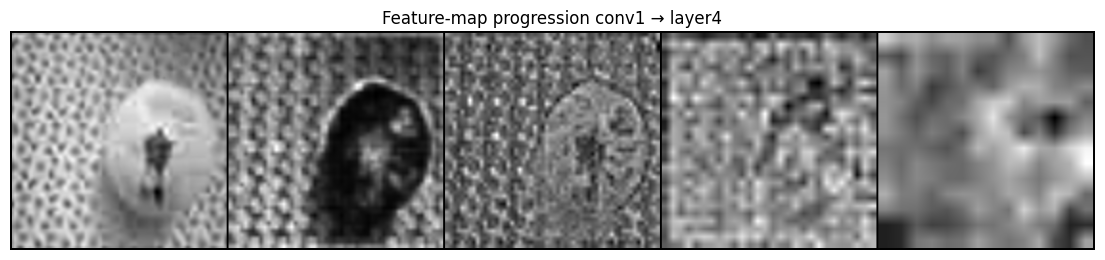

In [17]:
# Preprocess the sample image
img = helper_utils.preprocess_image(image_path, device)

# Extract and resize the most significant activation channel from each key layer
upsampled = feature_map_strip(
    img=img,
    model=fruits_model
)

# Display a horizontal sequence of the five processed feature maps
helper_utils.visual_strip(upsampled)

<a name='3'></a>
## 3 - Pixel Level Scrutiny: Saliency Maps

Visualizing feature maps showed you *what* patterns the network detects, but it did not tell you *which* of those patterns were important for the final decision. Does the model classify an apple as rotten because of the large brown spot, or because of the lighting in the background?

To answer this, you need **Saliency Maps**.

A saliency map visualizes the gradient of the prediction with respect to the input pixels. In simpler terms, it asks the model: "If I slightly change the color of this specific pixel, how much does your confidence in the prediction change?". This provides a detailed view of what the network is sensitive to at the input level, helping you verify that its attention is focused on the fruit rather than background clutter.

<a name='ex-3'></a>
### Exercise 3 - saliency_map

You will now implement `saliency_map`. This function generates a clear, pixel level explanation of the sensitivity of the model for a chosen class. By completing this, you will produce a heatmap where brighter values indicate exactly which pixels influence the prediction the most.

**Your Task**:

**Prepare the Input**:
* Create a clone of the `image_tensor` and detach it from the current graph to ensure a clean history.
* Explicitly enable gradient tracking on this new tensor so PyTorch knows to track operations on it (setting the `requires_grad_()` flag to `True`).

**Forward Pass**:
* Run the model on this prepared tensor to get the `output` logits.
* Select the specific score corresponding to `class_idx` from the output batch.

**Backward Pass**:
* (The model gradients are cleared for you).
* Trigger backpropagation from the `target_logit` to compute the gradients.

**Compute Saliency**:
* Access the gradients of the input image.
* Take the absolute value of the gradients and sum them across the color channel dimension to collapse it into a 2D map.

**Normalize**:
* Shift the map so the minimum value is 0.
* Scale the map so the maximum value is 1 (divide by the maximum plus a small epsilon, `1e-8`).

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you find yourself stuck, here is a more detailed breakdown.

**Prepare the Input:**

<code>image_tensor = # Use .clone() on image_tensor</code>

<code>image_tensor = # Next, use .detach() on image_tensor</code>

<code>image_tensor = # Set .requires_grad_(True) on image_tensor</code>


**Forward Pass:**

<code>output = call the model with image_tensor</code>

<code>target_logit = output[0, class_idx]</code>

**Backward Pass**: Simply call the backward method on the scalar you extracted.

<code>target_logit.backward()</code>

**Compute Saliency**: Access the `.grad` attribute of your input tensor.
<code>
    # Absolute value, then sum over channel dim (dim=1). 
    # [0] removes the batch dimension to leave (H, W).
    grads = image_tensor.grad.abs().sum(dim=1)[0]
</code>

**Normalize**: Apply standard Min/Max scaling in place.
<code>
    grads -= grads.min()
    grads /= grads.max() + 1e-8
</code>

</details>

In [18]:
# GRADED FUNCTION: saliency_map

def saliency_map(model, image_tensor, class_idx):
    """
    Generate a saliency map for a single image and class.

    This function computes the gradients of the target class score with respect 
    to the input image pixels. The resulting map highlights which pixels usually 
    influence the model's prediction the most.

    Arguments:
        model: A trained CNN model instance; should be in evaluation mode.
        image_tensor: Input image tensor with shape (1, 3, H, W). Must be pre-processed 
                      consistently with the model's training data.
        class_idx: The integer index of the specific target class logit to explain.

    Returns:
        heatmap: A torch.Tensor 2-D saliency heat-map normalised to the 
                 range [0, 1] with shape (H, W).
    """ 

### START CODE HERE ###

    # Create a clone of the input tensor to avoid modifying the original data
    image_tensor = image_tensor.clone()
    # Detach the tensor from the current computation graph to start a new tracking history
    image_tensor = image_tensor.detach()
    # Enable gradient tracking for the input tensor to allow backpropagation to the pixels
    image_tensor.requires_grad_(True)

    # Perform a forward pass of the image through the model
    output = model(image_tensor)
    # Extract the logit (raw score) corresponding to the target class index
    target_logit = output[0, class_idx]

    ### END CODE HERE ###

    # Clear any existing gradients in the model parameters
    model.zero_grad()

### START CODE HERE ###
    
    # Perform the backward pass to compute gradients of the target logit w.r.t the input
    target_logit.backward()

    # Compute the absolute value of the gradients and sum across the color channels (C dim)
    grads = image_tensor.grad.abs().sum(dim=1)[0]

    # Normalize the gradients to the [0, 1] range for visualization
    # Subtract the minimum value to shift the range to start at 0
    grads -= grads.min()
    # Divide by the maximum value (plus a small epsilon) to scale to [0, 1]
    grads /= grads.max() + 1e-8

    ### END CODE HERE ###

    # Detach the resulting heatmap from the computation graph
    heatmap = grads.detach()

    return heatmap

In [19]:
# Verify your implementation

# Load and preprocess a sample image
image_path = "./fruits_subset/Apple_Rotten/rottenApple_7.jpg"
img = helper_utils.preprocess_image(image_path, device)

# Define the target category for explanation (1 corresponds to 'rotten')
class_idx = 1

# Compute saliency map
heatmap = saliency_map(
    model=fruits_model,
    image_tensor=img,
    class_idx=class_idx
)

# Confirm the heatmap matches input dimensions and is normalized to [0, 1]
print("Shape and Range of the heatmap:\n")
print(f"Shape: {heatmap.shape}")
print(f"Range: min = {heatmap.min()}, max = {heatmap.max()}")

Shape and Range of the heatmap:

Shape: torch.Size([224, 224])
Range: min = 0.0, max = 1.0


#### Expected Output:

```
Shape and Range of the heatmap:

Shape: torch.Size([224, 224])
Range: min = 0.0, max = 1.0
```

In [20]:
# Test your code!
unittests.exercise_3(saliency_map)

 All tests passed!


<br>

Now that you have confirmed your code works, you can explore! The block below allows you to run your saliency analysis on different samples. Use the paths below to see if the model focuses on the actual defects (like rot spots) or if it gets distracted by irrelevant background details.

<details>
<summary><b><font color="white">📸 List of Image Paths to test with (Click to expand)</font></b></summary>
<br>
You can copy any of the paths below:

🍎 Apple

From **Apple_Healthy** (from index `0` to `9`)

* `image_path = "./fruits_subset/Apple_Healthy/FreshApple_0.jpg"`

From **Apple_Rotten** (from index `0` to `9`)

* `image_path = "./fruits_subset/Apple_Rotten/rottenApple_7.jpg"`

🥭 Mango

From **Mango_Healthy** (from index `0` to `9`)

* `image_path = "./fruits_subset/Mango_Healthy/FreshMango_4.jpg"`

From **Mango_Rotten** (from index `0` to `9`)

* `image_path = "./fruits_subset/Mango_Rotten/rottenMango_1.jpg`

🍅 Tomato

From **Tomato_Healthy** (from index `0` to `9`)

* `image_path = "./fruits_subset/Tomato_Healthy/FreshTomato_5.jpg"`

From **Tomato_Rotten** (from index `0` to `9`)

* `image_path = "./fruits_subset/Tomato_Rotten/rottenTomato_7.jpg"`

<br>

💡 You have images numbered from `0` to `9` in each folder. Feel free to change the number in the filename (e.g., changing `FreshApple_0.jpg` to `FreshApple_1.jpg`) to test with different images!

</details>

In [21]:
# EDITABLE CELL: Feel free to change the image path and class index

# Define the file path
image_path = "./fruits_subset/Apple_Rotten/rottenApple_7.jpg"

# Define the target category for explanation 
# (0 corresponds to 'fresh', 1 corresponds to 'rotten')
class_idx = 1

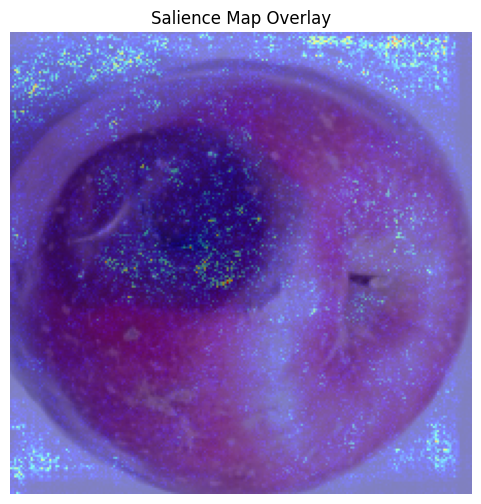

In [22]:
# Preprocess the sample image
img = helper_utils.preprocess_image(image_path, device)

# Compute saliency map
heatmap = saliency_map(
    model=fruits_model,
    image_tensor=img,
    class_idx=class_idx
)

# Display saliency map
helper_utils.display_saliency(image_tensor=img, heatmap=heatmap)

<br>

**Interpreting Saliency Maps: What to Look For**

When examining your results, keep these interpretation guidelines in mind:

1.  **Focus of Attention**: Bright regions indicate pixels that strongly influence the prediction of the model for the target class. For a "rotten" classification, you should expect to see highlights on damaged or discolored areas of the fruit.
2.  **Expected Behavior**: A well-trained model should highlight relevant features (e.g., brown spots, mold, holes) rather than background elements. If the saliency focuses heavily on the background, the model might be relying on spurious correlations.
3.  **Noise vs. Signal**: Saliency maps can be visually noisy, you will often see scattered bright pixels. Focus on the overall pattern rather than individual points. Look for coherent clusters of sensitivity.
4.  **Complementary to CAM**: Saliency maps provide pixel-level sensitivity (fine-grained), while CAM shows region-level importance (coarse-grained). Use both together for a complete picture. Saliency tells you *exactly which pixels*, while CAM tells you *which general areas*.
5.  **Limitations**:
    * Saliency maps show sensitivity, not strictly causation.
    * Sharp edges often appear salient simply because they represent high-frequency changes, even if they are not semantically critical.

<a name='4'></a>
## 4 - Regional Attention: Class Activation Maps

Saliency maps are powerful, but they can be visually noisy. They show you every single pixel that matters, which often results in a scattered "star map" of high-contrast edges. Sometimes, you want a broader answer. Instead of asking "which pixel matters?", you want to ask "which **region** matters?"

For this, you use **Class Activation Maps (CAM)**.

CAMs work by combining the feature maps from the very last convolutional layer, where the model has its most advanced understanding of shapes and objects, with the final classification weights. This produces a smooth heatmap that highlights the entire object or region the model is focusing on.

**Why "Simplified" CAM?**

In this section, you will use a direct computation method rather than the gradient-based approach (Grad-CAM) often seen in generic tools. This is possible because your ResNet-50 inspector uses a specific architectural pattern: Global Average Pooling (GAP) followed by a fully connected layer. This structure allows you to mathematically map the weights of the final layer directly back onto the feature maps, offering a clean and efficient way to visualize attention without the need for backpropagation.

<a name='ex-4'></a>
### Exercise 4 - simplified_cam

You will now implement `simplified_cam`. This function generates a clear, region-level view of the evidence the model uses for a specific class, complementing the pixel-level sensitivity you obtained with saliency maps.

**Your Task**:

**Register Hook**:
* Attach the `save_fmap` hook (provided for you) to the third convolution of the final bottleneck block in `layer4` (`model.layer4[-1].conv3`).

**Compute CAM**:
* **Retrieve Features** - Extract the captured feature maps from the `fmap_holder` dictionary.
* **Get Weights** -  Access the weight vector for the specific `class_idx` from the model's fully connected layer (`model.fc.weight`).
* **Weighted Sum** -  Compute the dot product between the class weights and the feature channels. You should sum over the channel dimension to produce a single 2D map. `torch.einsum` is an efficient tool for this.
* **ReLU** - Apply ReLU to the resulting map to keep only positive contributions (implemented for you).
* **Normalize** - Scale the map to the range `[0, 1]` (min/max normalization). Use epsilon as `1e-8`.

**Upsample**:
* Resize the map to match the input image dimensions (`H`, `W`).
* **Note**: `F.interpolate` requires a 4D input (Batch, Channel, Height, Width), but your map is currently 2D. You will need to add two dummy dimensions before interpolating.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you find yourself stuck, here is a more detailed breakdown.

**Register Hook:** Target the specific layer attribute.

<code>hook = model.layer4[-1].conv3.register_forward_hook(save_fmap)</code>

**Compute CAM:**

* Features: <code>feats = fmap_holder["feat"]</code>
* Weights: <code>weight_vec = model.fc.weight[class_idx]</code>
* Weighted Sum: Use Einstein summation. 'c' is channels, 'h' and 'w' are spatial dims.
    * <code>cam = torch.einsum("c,chw->hw", weight_vec, feats.squeeze(0))</code>
* Normalize: <code>cam = (cam - cam.min()) / (cam.max() + 1e-8)</code>

**Upsample:** You need to unsqueeze the tensor twice to go from (H, W) to (1, 1, H, W).
```python
cam_up = F.interpolate(
    cam.unsqueeze(0).unsqueeze(0),
    size=(H, W),
    mode="bilinear",
    align_corners=False,
)[0, 0]
```

</details>

In [23]:
# GRADED FUNCTION: simplified_cam

def simplified_cam(model, image_tensor, class_idx):
    """
    Generates a simplified Class Activation Map (CAM) for a specific image and class.

    This function extracts the feature maps from the final convolutional layer 
    and computes a weighted sum using the weights from the final fully connected 
    layer. The resulting map highlights regions of the image that contributed 
    most to the prediction of the target class.

    Arguments:
        model: A trained ResNet-style neural network module.
        image_tensor: The input image tensor (1, 3, H, W), normalized for the model.
        class_idx: The integer index of the target class to explain.

    Returns:
        heatmap: A 2-D tensor representing the class activation heatmap, 
                 scaled to [0, 1] with the same spatial dimensions as the input.
    """

    # Initialize an empty dictionary to store the captured feature maps
    fmap_holder = {}

    # Define a hook function to detach and store the layer output during the forward pass
    def save_fmap(_, __, output): 
        fmap_holder["feat"] = output.detach()

### START CODE HERE ###

    # Register the forward hook on the final convolutional layer to capture features
    hook = model.layer4[-1].conv3.register_forward_hook(save_fmap)

    ### END CODE HERE ###

    # Perform a forward pass with the image to trigger the hook
    with torch.no_grad():
        _ = model(image_tensor) 

    # Remove the hook to clean up the model and stop capturing data
    hook.remove() 

    ### START CODE HERE ###
    
    # Retrieve the captured feature maps from the dictionary
    feats = fmap_holder["feat"]
    # Extract the weight vector corresponding to the target class from the FC layer
    weight_vec = model.fc.weight[class_idx]

    # Compute the weighted sum of feature maps along the channel dimension
    # Uses Einstein summation: 'c' (channels), 'chw' (features) -> 'hw' (spatial map)
    cam = torch.einsum("c,chw->hw", weight_vec, feats.squeeze(0))

    # Apply ReLU to retain only positive contributions to the class score
    cam = F.relu(cam) 
    # Normalize the activation map values to the range [0, 1]
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    ### END CODE HERE ###

    # Retrieve the spatial dimensions (Height, Width) of the original input
    H, W = image_tensor.shape[2:]

    ### START CODE HERE ###

    # Upsample the low-resolution activation map to match the input image size
    cam_up = F.interpolate( 
        # Add batch and channel dimensions required for interpolation (1, 1, H, W)
        cam.unsqueeze(0).unsqueeze(0),
        # Specify the target output size matching the input image
        size=(H, W),
        # Use bilinear interpolation for smooth resizing
        mode="bilinear", 
        # Disable corner alignment to align the geometric centers of pixels
        align_corners=False, 
    )[0, 0] 

    ### END CODE HERE ###

    # Detach the result from the graph and move to CPU if necessary
    heatmap = cam_up.cpu().detach()

    return heatmap

In [24]:
# Verify your implementation

# Load and preprocess a sample image
image_path = "./fruits_subset/Apple_Rotten/rottenApple_5.jpg"
img = helper_utils.preprocess_image(image_path, device)

# Define the target category for explanation (1 corresponds to 'rotten')
class_idx = 1

# Compute CAM
heatmap = simplified_cam(
    model=fruits_model, 
    image_tensor=img, 
    class_idx=class_idx
)

# Verify shape and range
print("Shape and Range of the CAM:\n")
print(f"Shape: {heatmap.shape}")
print(f"Range: min = {heatmap.min()}, max = {heatmap.max()}")

Shape and Range of the CAM:

Shape: torch.Size([224, 224])
Range: min = 0.0, max = 0.9886835813522339


#### Expected Output (Approximately):

```
Shape and Range of the CAM:

Shape: torch.Size([224, 224])
Range: min = 0.0, max = 0.9886835217475891
```

In [25]:
# Test your code!
unittests.exercise_4(simplified_cam)

 All tests passed!


<br>

Now that you have confirmed your code works, you can explore! The block below allows you to generate heatmaps for different fruits. Use the paths below to see if the model's "attention" aligns with the rotten spots on the fruit, or if it is looking at the stem or background.

<details>
<summary><b><font color="white">📸 List of Image Paths to test with (Click to expand)</font></b></summary>
<br>
You can copy any of the paths below:

🍎 Apple

From **Apple_Healthy** (from index `0` to `9`)

* `image_path = "./fruits_subset/Apple_Healthy/FreshApple_0.jpg"`

From **Apple_Rotten** (from index `0` to `9`)

* `image_path = "./fruits_subset/Apple_Rotten/rottenApple_7.jpg"`

🥭 Mango

From **Mango_Healthy** (from index `0` to `9`)

* `image_path = "./fruits_subset/Mango_Healthy/FreshMango_4.jpg"`

From **Mango_Rotten** (from index `0` to `9`)

* `image_path = "./fruits_subset/Mango_Rotten/rottenMango_1.jpg`

🍅 Tomato

From **Tomato_Healthy** (from index `0` to `9`)

* `image_path = "./fruits_subset/Tomato_Healthy/FreshTomato_5.jpg"`

From **Tomato_Rotten** (from index `0` to `9`)

* `image_path = "./fruits_subset/Tomato_Rotten/rottenTomato_7.jpg"`

<br>

💡 You have images numbered from `0` to `9` in each folder. Feel free to change the number in the filename (e.g., changing `FreshApple_0.jpg` to `FreshApple_1.jpg`) to test with different images!

</details>

In [26]:
# EDITABLE CELL: Feel free to change the image path and class index

# Preprocess the sample image
image_path = "./fruits_subset/Apple_Rotten/rottenApple_5.jpg"

# Define the target category for explanation 
# (0 corresponds to 'fresh', 1 corresponds to 'rotten')
class_idx = 1

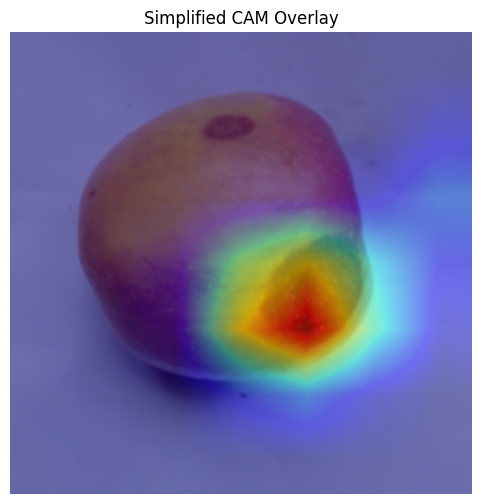

In [27]:
# Preprocess the sample image
img = helper_utils.preprocess_image(image_path, device)

# Compute CAM
heatmap = simplified_cam(
    model=fruits_model, 
    image_tensor=img, 
    class_idx=class_idx
)

# Display CAM
helper_utils.display_cam(img, heatmap)

<a name='5'></a>
## 5 - Comparison of Interpretability Techniques

You have now implemented three powerful techniques for understanding model behavior. Here is how they compare:

| **Aspect** | **Feature Hierarchy** | **Saliency Maps** | **Class Activation Maps (CAM)** |
|------------|----------------------|-------------------|--------------------------------|
| **What it shows** | Evolution of features across layers | Pixel-level gradient sensitivity | Region-level class evidence |
| **Granularity** | Layer-by-layer channel responses | Individual pixels | Coarse spatial regions |
| **Computation** | Forward hooks only | Backpropagation to input | Forward hooks + FC weights |
| **Speed** | Fast ⚡ | Medium ⏱️ | Fast ⚡ |
| **Use case** | Understanding feature learning | Finding important pixels | Localizing class evidence |
| **Output** | Multiple feature maps | Single heatmap per class | Single heatmap per class |
| **Requires gradients?** | No | Yes | No |
| **Architecture constraints** | None | None | Requires GAP→FC (or use Grad-CAM) |
| **Best for** | Model debugging, visualization | Adversarial analysis, fine details | Model trustworthiness, localization |

**When to use each:**

- **Feature Hierarchy**: Use when you want to understand *how* a model learns, what patterns emerge at different depths, or debug training issues.
  
- **Saliency Maps**: Use when you need *precise pixel-level explanations*, are concerned about adversarial vulnerabilities, or want to understand fine-grained sensitivities.
  
- **CAM/Grad-CAM**: Use when you need *human-interpretable region highlights*, want to verify the model is looking at the right object, or need coarse localization for weakly-supervised tasks.

**Pro Tip**: Combine multiple techniques! For example:
1. Use **CAM** to verify the model focuses on the fruit (not background)
2. Use **Saliency** to see exactly which pixels (e.g., specific spots, edges) drive the decision
3. Use **Feature Hierarchy** to understand what low/mid/high-level features the model learned

This multi-method approach gives you comprehensive understanding of your model's behavior.

---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. Feel free to [submit](#submission) your work now. The grading process runs in the background, so it will not disrupt your progress and you can continue on with the rest of the material.

**🚨 IMPORTANT NOTE** If you have passed all tests within the notebook, but the autograder shows a system error after you submit your work:

<div style="background-color: #1C1C1E; border: 1px solid #444444; color: #FFFFFF; padding: 15px; border-radius: 5px;">
    <p><strong>Grader Error: Grader feedback not found</strong></p>
    <p>Autograder failed to produce the feedback...</p>
</div>
<br>

This is typically a temporary system glitch. The most common solution is to resubmit your assignment, as this often resolves the problem. Occasionally, it may be necessary to resubmit more than once. 
>
If the error persists, please reach out for support in the [DeepLearning.AI Community Forum](https://community.deeplearning.ai/c/course-q-a/pytorch-for-developers/pytorch-advanced-architectures-and-deployment/562).

---

<a name='6'></a>
## 6 - (Optional) Dreaming up Defects: Generative AI

You have spent this assignment auditing an AI inspector, dissecting its feature maps and heatmaps to verify it understands what a "rotten" apple looks like. But what happens when you need to train this inspector to recognize a new, rare type of defect, like a specific insect bite, and you do not have enough real photos?

This is a common bottleneck in industrial AI: **data scarcity**. Collecting thousands of images of rare spoilage conditions is expensive and time consuming.

In this final optional section, you will flip the script. Instead of analyzing how models *interpret* images, you will explore how they can *create* new ones. You will leverage **Stable Diffusion**, a state of the art generative model, to synthesize realistic training data from scratch. This transition from **interpretation to generation** demonstrates the full power of deep learning models that not only recognize visual patterns but can also build them.

<a name='6-1'></a>
### 6.1 - Setting up Stable Diffusion

Your first step is to initialize the creative engine. You will use the Hugging Face `diffusers` library to load a pre-trained **Stable Diffusion** model. This pipeline bundles all the necessary components, the text encoder, the unet, and the variational autoencoder (VAE), into a single, easy to use object.

<a name='exu-1'></a>
### Ungraded Exercise 1 - load_sd_pipeline

Implement `load_sd_pipeline`. This function initializes the core text-to-image generation pipeline using a pre-trained model and moves it to the correct computing device.

**Your Task**:

* **Initialize the Pipeline**: Use the `StableDiffusionPipeline.from_pretrained` method to load the model defined by `pretrained_model_name_or_path=model_id`.
* **Configure Precision**: To optimize memory usage, you must load the model using 16-bit floating point precision.
    * Set `torch_dtype` to `torch.float16`.
    * Set the `variant` to `"fp16"`.
* **Manage Loading Source**:
    * Set `cache_dir` to `"./models"` to ensure the model loads from the correct local path.
    * Set `local_files_only` to `True` to prevent the pipeline from attempting to download files from the internet.
* **Device Transfer**: Finally, move the initialized pipeline to the specified `device` (e.g., CUDA or CPU) using the `.to()` method.

<details>
<summary><b><font color="green">Solution - Ungraded Exercise 1 (Click to expand if you are stuck)</font></b></summary>

<br>

```python
def load_sd_pipeline(device, model_id="stabilityai/stable-diffusion-2-base"):
    """
    Initializes the Stable Diffusion pipeline from a pretrained model identifier 
    and transfers it to the specified computing device.

    Arguments:
        device: The target device (e.g., 'cuda', 'mps', 'cpu') for model execution.
        model_id: The repository ID of the pretrained model to load.
    """
    ### START CODE HERE ###
    
    # Initialize the pipeline using 16-bit floating point precision and load from local cache
    pipe = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name_or_path=model_id,
        torch_dtype=torch.float16,
        variant="fp16",
        cache_dir="./models",
        local_files_only=True
    ).to(device)
    
    ### END CODE HERE ###
    
    return pipe
```

</details>

In [30]:
# EDITABLE CELL: Ungraded Exercise 1 - load_sd_pipeline

def load_sd_pipeline(device, model_id="stabilityai/stable-diffusion-2-base"):
    """
    Initializes the Stable Diffusion pipeline from a pretrained model identifier 
    and transfers it to the specified computing device.

    Arguments:
        device: The target device (e.g., 'cuda', 'mps', 'cpu') for model execution.
        model_id: The repository ID of the pretrained model to load.
    """
### START CODE HERE ###
    
    # Initialize the pipeline using 16-bit floating point precision and load from local cache
    pipe = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name_or_path=model_id,
        torch_dtype=torch.float16,
        variant="fp16",
        cache_dir="./models",
        local_files_only=True 
    ).to(device) 
    
    ### END CODE HERE ###
    
    return pipe

* **Note**: You can safely ignore the <code>`torch_dtype` is deprecated! Use `dtype` instead!</code> warning.

In [31]:
# INITIALIZE pipe

# Clear any existing reference to pipe to free up GPU/CPU memory before initializing
if "pipe" in globals():
    del pipe
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

try:
    # Check if model snapshot exists, otherwise extract it
    helper_utils.check_model_snapshot()
    
    # Attempt to initialize the Stable Diffusion pipeline on the detected device
    pipe = load_sd_pipeline(device)

    print("\nLoading Complete!")
    
except Exception as e:
    # Catch and report errors during model initialization or weight loading
    print(f"""\
    An error occurred while loading the pipeline.

    Refer the solutions for the correct implementation.
    
    Error: {e}
    """)
    
    # Clear memory if the pipeline failed to load or existed previously
    if "pipe" in globals():
        del pipe
        
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Ensure pipe is set to None to prevent subsequent errors in generation cells
    pipe = None

Snapshots directory exists and is not empty. Skipping extraction.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!



Loading Complete!


<a name='6-2'></a>
### 6.2 - Generating Synthetic Data

Now that your engine is running, you need a control panel. You will create a function that takes your text description, like `"A mango with a wormhole"`, and turns it into a pixel-perfect image.

This function will handle the critical details of **reproducibility**. In scientific and industrial contexts, you often need to recreate a specific result. By controlling the random seed, you ensure that if you find a perfect synthetic example of a rare defect, you can generate it again exactly as it appeared.

<a name='exu-2'></a>
### Ungraded Exercise 2 - generate_sd_image

Implement `generate_sd_image`. This function orchestrates the actual generation process, running the text prompt through the diffusion model to produce a visual output.

**Your Task**:

* **Setup Reproducibility**:
    * Create a `torch.Generator` targeted at the correct `device` (which you can retrieve from `pipe.device`).
    * Manually set the seed of this generator using the integer provided in the `seed` argument. This ensures that if you run the code again with the same settings, you get the exact same image.
* **Run Inference**:
    * Call the `pipe` object you initialized earlier.
    * Pass in the `prompt`, `negative_prompt`, and `generator`.
    * Set `num_inference_steps` to the steps argument.
    * Access the `.images` attribute of the returned object and select the first item (index `0`) to get the final PIL image.

<details>
<summary><b><font color="green">Solution - Ungraded Exercise 2 (Click to expand if you are stuck)</font></b></summary>

<br>

```python
def generate_sd_image(pipe, prompt, negative_prompt, seed, steps, save_dir="synthetic"):
    """
    Generates a single image from a text prompt using a pre-loaded Stable Diffusion pipeline.

    This function sets a deterministic seed for reproducibility, runs the inference 
    process, and saves the resulting image to a structured directory based on the prompt.

    Arguments:
        pipe: The initialized Stable Diffusion pipeline instance.
        prompt: The positive text description of the desired image.
        negative_prompt: Text description of elements to exclude from the image.
        seed: An integer value to initialize the random number generator.
        steps: The number of denoising steps to perform during inference.
        save_dir: The root directory path where the generated image will be saved.

    Returns:
        image: The generated PIL Image object.
    """
    # Retrieve the computing device (CPU/GPU) associated with the pipeline
    device = pipe.device
    
    ### START CODE HERE ###

    # Create a random number generator on the specific device and set the seed manually
    generator = torch.Generator(device=device).manual_seed(seed)
    
    # Run the pipeline to generate the image based on the provided prompts and configuration
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=steps,
        generator=generator,
    ).images[0]

    ### END CODE HERE ###

    # Create a filename slug using the first three words of the prompt
    slug = "_".join(prompt.lower().split()[:3]) 
    
    # Construct the full output directory path
    out_dir = Path(save_dir) / slug 
    
    # Create the directory if it does not exist, including parent directories
    out_dir.mkdir(parents=True, exist_ok=True) 
    
    # Define the complete file path for the image
    out_path = out_dir / f"img_{seed}.png" 
    
    # Save the generated image to the file system
    image.save(out_path)

    # Log the save location to the console
    print(f"\nImage saved to {out_path}\n") 

    return image
```

</details>

In [35]:
# EDITABLE CELL: Ungraded Exercise 2 - generate_sd_image

def generate_sd_image(pipe, prompt, negative_prompt, seed, steps, save_dir="synthetic"):
    """
    Generates a single image from a text prompt using a pre-loaded Stable Diffusion pipeline.

    This function sets a deterministic seed for reproducibility, runs the inference 
    process, and saves the resulting image to a structured directory based on the prompt.

    Arguments:
        pipe: The initialized Stable Diffusion pipeline instance.
        prompt: The positive text description of the desired image.
        negative_prompt: Text description of elements to exclude from the image.
        seed: An integer value to initialize the random number generator.
        steps: The number of denoising steps to perform during inference.
        save_dir: The root directory path where the generated image will be saved.

    Returns:
        image: The generated PIL Image object.
    """
    # Retrieve the computing device (CPU/GPU) associated with the pipeline
    device = pipe.device
    
    ### START CODE HERE ###

    # Create a random number generator on the specific device and set the seed manually
### START CODE HERE ###

    # Create a random number generator on the specific device and set the seed manually
    generator = torch.Generator(device=device).manual_seed(seed)
    
    # Run the pipeline to generate the image based on the provided prompts and configuration
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=steps,
        generator=generator,
    ).images[0] 

    ### END CODE HERE ###

    # Create a filename slug using the first three words of the prompt
    slug = "_".join(prompt.lower().split()[:3]) 
    
    # Construct the full output directory path
    out_dir = Path(save_dir) / slug 
    
    # Create the directory if it does not exist, including parent directories
    out_dir.mkdir(parents=True, exist_ok=True) 
    
    # Define the complete file path for the image
    out_path = out_dir / f"img_{seed}.png" 
    
    # Save the generated image to the file system
    image.save(out_path)

    # Log the save location to the console
    print(f"\nImage saved to {out_path}\n")

    return image

In [36]:
# EDITABLE CELL: Feel free to change the prompt, negative_prompt, seed and steps

# Text description of the desired synthetic fruit image
prompt = "A mango with a small hole made by a worm in the middle."

# Features or styles to be excluded from the generated output
negative_prompt = "Fresh, intact."

# Seed for reproducible results
seed = 42

# Number of steps; higher values typically improve quality
steps = 50

**🔧 Troubleshooting Tip**: If your implementation is correct, yet running the *cell below* returns an `Error: 'NoneType' object is not callable`, it likely means that your `pipe` object has been set to `None`. Please re-run the cell containing the comment `# INITIALIZE pipe` (located under the **Ungraded Exercise 1 - load_sd_pipeline** section) to re-initialize it.

In [37]:
try:
    # Execute the diffusion process to generate a synthetic fruit image
    img = generate_sd_image(
        pipe=pipe,
        prompt=prompt, 
        negative_prompt=negative_prompt,
        seed=seed, 
        steps=steps
    )
    
    # Render the final generated PIL image without axis labels
    plt.axis('off')
    plt.imshow(img)
    
except Exception as e:
    # Handle and log any errors occurring during the inference process
    print(f"""\
    An error occurred in the generation.

    Refer the solutions for the correct implementation.
    
    Error: {e}
    """)
    
    # Clear memory if the pipeline failed to load or existed previously
    if "pipe" in globals():
        del pipe
        
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Ensure pipe is set to None to prevent subsequent errors in generation cells
    pipe = None

    An error occurred in the generation.

    Refer the solutions for the correct implementation.

    Error: 'NoneType' object has no attribute 'device'
    


<a name='6-3'></a>
### 6.3 - Peeking into the Diffusion Process

You have generated a final image, but the magic happens in the steps between pure noise and the final pixel. Stable Diffusion works by iteratively removing noise, a process called **denoising**. It starts with a tensor of random static and, over a series of steps (usually 20–50), gently nudges the pixel values until they match the patterns requested in your text prompt.

Visualizing this evolution is not just cool; it is a form of debugging. It helps you see *when* the model decides on the shape of the fruit versus when it refines the texture of the skin. To do this, you need to interrupt the pipeline while it runs.

<a name='exu-3'></a>
### Ungraded Exercise 3 - denoising_movie

Implement `denoising_movie`. This function visualizes how the image evolves during the diffusion process by intercepting the model at specific steps. You will use a callback mechanism to "peek" inside the pipeline, decode the intermediate latent vectors into viewable images, and assemble them into a grid.

**Your Task**:

* **Define the Callback**:
    * Create a function `grab_frame` that accepts the standard callback arguments (`pipeline`, `step_idx`, `timestep`, `callback_kwargs`).
    * **Check the Step**: Only proceed if `step_idx` is in your list of `capture_steps`.
    * **Retrieve Latents**: Extract the `latents` tensor from the `callback_kwargs` dictionary.
    * **Decode**:
        * Scale the latents by dividing them by `pipe.vae.config.scaling_factor`.
        * Pass the scaled latents to the VAE decoder (`pipe.vae.decode`).
        * Set `return_dict=False` to get the raw tuple output.
    * **Post-process**: Use `pipe.image_processor.postprocess` to convert the decoded tensor into a PIL image (set `output_type="pil"`).
    * **Store**: Save the resulting image in the `frames` dictionary using `step_idx` as the key.
    * **Return**: You must return `callback_kwargs` at the end of the function.

<br>

* **Run the Pipeline**:
    * Call the `pipe` with the `prompt`, `num_inference_steps`, and `generator`.
    * **Attach the Callback**: Pass your `grab_frame` function to the `callback_on_step_end` argument.

<br>

* **Order Results**: Create a list called `ordered_frames` containing the images from the `frames` dictionary, sorted according to the order in `capture_steps`.

<details>
<summary><b><font color="green">Solution - Ungraded Exercise 3 (Click to expand if you are stuck)</font></b></summary>

<br>

```python
def denoising_movie(pipe, prompt, seed, steps, capture_steps, save_grid_path="timelapse.png"):
    """
    Captures intermediate denoising frames from the Stable Diffusion process and 
    assembles them into a grid image.

    This function utilizes a callback mechanism to intercept the latent vectors 
    at specific steps, decodes them into images, and saves a composite 2x2 grid 
    visualization.

    Arguments:
        pipe: The pre-loaded Stable Diffusion pipeline instance.
        prompt: The positive text description for generation.
        seed: An integer value for deterministic random noise generation.
        steps: The total number of inference steps to perform.
        capture_steps: A list of integer indices specifying which steps to capture.
        save_grid_path: The file path where the final grid image will be saved.

    Returns:
        ordered_frames: A list of PIL Image objects corresponding to the captured steps.
    """

    # Dictionary to store the captured frames indexed by step number
    frames = {}

    ### START CODE HERE ###
    
    # Define the callback function to grab frames
    def grab_frame(pipeline, step_idx, timestep, callback_kwargs): 
        
        # Check if the current step is one you want to save
        if step_idx in capture_steps:
            
            # Extract the latent representation from the callback arguments
            latents = callback_kwargs["latents"]
            
            with torch.no_grad():
                # Decode the latents using the VAE (Variational Autoencoder)
                img = pipe.vae.decode(
                    # Scale the latents by the VAE's scaling factor before decoding
                    latents / pipe.vae.config.scaling_factor,
                    # Ensure the output is a tensor, not a dictionary
                    return_dict=False
                )[0]
            
            # Convert the raw tensor output into a PIL image
            pil = pipe.image_processor.postprocess(img, output_type="pil")[0]
            
            # Store the result
            frames[step_idx] = pil
            
        return callback_kwargs

    ### END CODE HERE ###

    # Initialize the generator for reproducibility
    generator = torch.Generator(pipe.device).manual_seed(seed)

    ### START CODE HERE ###

    # Run the pipeline with the callback attached
    _ = pipe(
        prompt=prompt,
        num_inference_steps=steps,
        generator=generator,
        # Attach the function to run at the end of every step
        callback_on_step_end=grab_frame,
    )

    # Order frames according to the requested `capture_steps` list
    ordered_frames = [frames[s] for s in capture_steps]

    ### END CODE HERE ###
    
    # Build grid (Standard PIL image processing)
    w, h = ordered_frames[0].size 
    grid = Image.new("RGB", (w * 2, h * 2)) 
    for idx, frame in enumerate(ordered_frames): 
        row, col = divmod(idx, 2) 
        grid.paste(frame, (col * w, row * h)) 

    grid.save(save_grid_path) 
    print(f"Timelapse grid saved to {save_grid_path}") 

    return ordered_frames
```

</details>

In [38]:
# EDITABLE CELL: Ungraded Exercise 3 - denoising_movie

def denoising_movie(pipe, prompt, seed, steps, capture_steps, save_grid_path="timelapse.png"):
    """
    Captures intermediate denoising frames from the Stable Diffusion process and 
    assembles them into a grid image.

    This function utilizes a callback mechanism to intercept the latent vectors 
    at specific steps, decodes them into images, and saves a composite 2x2 grid 
    visualization.

    Arguments:
        pipe: The pre-loaded Stable Diffusion pipeline instance.
        prompt: The positive text description for generation.
        seed: An integer value for deterministic random noise generation.
        steps: The total number of inference steps to perform.
        capture_steps: A list of integer indices specifying which steps to capture.
        save_grid_path: The file path where the final grid image will be saved.

    Returns:
        ordered_frames: A list of PIL Image objects corresponding to the captured steps.
    """

    # Dictionary to store the captured frames indexed by step number
    frames = {}

  ### START CODE HERE ###
    
    # Define the callback function to grab frames
    def grab_frame(pipeline, step_idx, timestep, callback_kwargs): 
        
        # Check if the current step is one you want to save
        if step_idx in capture_steps:
            
            # Extract the latent representation from the callback arguments
            latents = callback_kwargs["latents"]
            
            with torch.no_grad():
                # Decode the latents using the VAE (Variational Autoencoder)
                img = pipe.vae.decode(
                    # Scale the latents by the VAE's scaling factor before decoding
                    latents / pipe.vae.config.scaling_factor,
                    # Ensure the output is a tensor, not a dictionary
                    return_dict=False
                )[0] 
            
            # Convert the raw tensor output into a PIL image
            pil = pipe.image_processor.postprocess(img, output_type="pil")[0]
            
            # Store the result
            frames[step_idx] = pil
            
        return callback_kwargs

    ### END CODE HERE ###

    # Initialize the generator for reproducibility
    generator = torch.Generator(pipe.device).manual_seed(seed)

    ### START CODE HERE ###

    # Run the pipeline with the callback attached
    _ = pipe( 
        prompt=prompt,
        num_inference_steps=steps,
        generator=generator,
        # Attach the function to run at the end of every step
        callback_on_step_end=grab_frame,
    ) 

    # Order frames according to the requested `capture_steps` list
    ordered_frames = [frames[s] for s in capture_steps]

    ### END CODE HERE ###
    
    # Build grid (Standard PIL image processing)
    w, h = ordered_frames[0].size 
    grid = Image.new("RGB", (w * 2, h * 2)) 
    for idx, frame in enumerate(ordered_frames): 
        row, col = divmod(idx, 2) 
        grid.paste(frame, (col * w, row * h)) 

    grid.save(save_grid_path) 
    print(f"Timelapse grid saved to {save_grid_path}") 

    return ordered_frames

In [39]:
# EDITABLE CELL: Feel free to change the prompt, seed, steps and capture_steps

# Target subject for the denoising visualization
prompt = "A healthy mango."

# Fixed seed to ensure the same noise pattern is used for the timelapse
seed = 42

# Total number of diffusion iterations
steps = 50

# Specific iteration indices to capture for the final grid
capture_steps = [0, 10, 20, 30, 50]

**🔧 Troubleshooting Tip**: If your implementation is correct, yet running the *cell below* returns an `Error: 'NoneType' object is not callable`, it likely means that your `pipe` object has been set to `None`. Please re-run the cell containing the comment `# INITIALIZE pipe` (located under the **Ungraded Exercise 1 - load_sd_pipeline** section) to re-initialize it.

In [40]:
try:
    # Run the diffusion process and capture latents at specific intervals
    ordered_frames = denoising_movie(
        pipe=pipe,
        prompt=prompt,
        seed=seed, 
        steps=steps,
        capture_steps=capture_steps
    )

    # Load and display the composite grid showing the image evolution
    grid_image = plt.imread("timelapse.png")
    plt.axis('off')
    plt.imshow(grid_image)
    
except Exception as e:
    # Handle failures in the callback or VAE decoding process
    print(f"""\
    An error occurred in the denoising.

    Refer the solutions for the correct implementation.
    
    Error: {e}
    """)
    
    # Clear memory if the pipeline failed to load or existed previously
    if "pipe" in globals():
        del pipe
        
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Ensure pipe is set to None to prevent subsequent errors in generation cells
    pipe = None

    An error occurred in the denoising.

    Refer the solutions for the correct implementation.

    Error: 'NoneType' object has no attribute 'device'
    


## Conclusion

Congratulations on finishing this assignment! You have successfully audited a deep learning model, transforming it from a mysterious "black box" into an interpretable "glass box." By visualizing feature hierarchies, you observed how the network builds understanding from simple edges to complex objects. Through Saliency Maps and Class Activation Maps, you verified that the model focuses on relevant fruit defects rather than background noise, ensuring its decisions are trustworthy.

In the optional section, you went a step further by leveraging Stable Diffusion to address the challenge of data scarcity. Instead of just analyzing images, you used generative AI to synthesize realistic examples of rare defects, demonstrating how AI can be used to create data to train better models. You are now equipped with a powerful toolkit to explain, debug, and improve computer vision systems in the real world.